In [238]:
%matplotlib inline
from pycocotools.coco import COCO
from collections import OrderedDict
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import copy

import os
import itertools

import holoviews as hv
import plotly.graph_objects as go
import plotly.express as pex

import pandas as pd
pd.options.plotting.backend = "matplotlib"
from mlxtend.frequent_patterns import fpgrowth
from tqdm.auto import tqdm

pylab.rcParams['figure.figsize'] = (25, 10)

## Chargement des données

In [233]:
annDir   = '/Volumes/F_LEDOYEN/ms_coco/annotations'
annFiles = {type : f'{annDir}/instances_{type}2017.json' for type in ["train", "val"]}
dataDir  = '../../data'
types = ["all"] #["val", "train", "all"]
classesOccFiles = {type : f'{dataDir}/instances_{type}2017.classes_occ.csv' for type in types}


def getAnnDf(coco):
    index = pd.MultiIndex.from_tuples(itertools.product(coco.getCatIds(),["small","medium","large", "total"]),
           names=['class', 'instance_size'])
                                      
    def getSize(size):
        ranges = [(0, 32**2,"small"), (32**2, 96**2, "medium"), (96**2, float("inf"), "large")]
        for min, max, label in ranges:
            if min <= size and size < max : return label
        
    df = pd.DataFrame(0, index=coco.getImgIds(), columns=index)
    nb_imgs = len(coco.getImgIds())
    img_ids = coco.getImgIds()
    for i in tqdm(range(nb_imgs)):
        img_id = img_ids[i]
        for ann in coco.imgToAnns[img_id]:
            cat_id = ann["category_id"]
            size = ann["area"]
            df[cat_id, getSize(size)][img_id] += 1
            df[cat_id, "total"][img_id] += 1
    df.columns.set_levels([v["name"] for k,v in cocos["val"].cats.items()],level=0,inplace=True)
    return df

def loadOccMat(type):
    file = classesOccFiles[type]
    df = None
    if os.path.exists(file):
        print(f"({type}) loading from csv file")
        df = pd.read_csv(file, header=[0,1], index_col=[0])
        print(f"({type}) loading from csv file Done")
    else : 
        print(f"({type}) extraction of occurence matrix")
        df = getAnnDf(cocos[type])
        df.to_csv(file)
    return df
    
def plot_freqs(size):
    itemsets = res[res["len"] == size]
    itemsets = itemsets.sort_values(by=["support_nb"])
    nb_itemsets = len(itemsets)
    bar_width = 1
    x_pos = np.arange(nb_itemsets*2, step=2)
    support = itemsets["support_nb"]

    plt.bar(x_pos, support, width=bar_width, align="edge")
    plt.xticks(x_pos, itemsets.itemsets, rotation=45, ha="right", rotation_mode="anchor")
    locs, labels = plt.yticks()
    plt.yticks(locs, [r'{:.0f} $\approx$ {:.2f} %'.format(label, label / len(m)) for label in locs])
    plt.ylabel("support (nb d'images)")
    plt.title(r'support des couples de classes, $\vert \mathcal{{T}} \vert = {}$'.format(len(m)))
    plt.savefig(f'out/stats/supp.{size}items.png')

In [234]:
#cocos = {type : COCO(file) for type, file in annFiles.items()}

In [235]:
occMats = {type : loadOccMat(type) for type in types}

(all) loading from csv file
(all) loading from csv file Done


In [236]:
occMats["all"]

class         person                    bicycle                      car  \
instance_size  small medium large total   small medium large total small   
397133             0      1     1     2       0      0     0     0     0   
37777              0      0     0     0       0      0     0     0     0   
252219             0      2     1     3       0      0     0     0     0   
87038             11      3     0    14       1      1     0     2     0   
174482             0      0     0     0       0      0     1     1     3   
...              ...    ...   ...   ...     ...    ...   ...   ...   ...   
444010             0      8     4    12       0      0     0     0     0   
565004             0      1     1     2       0      0     0     0     0   
516168             0      0     1     1       0      0     0     0     0   
547503             1      4     1     6       0      0     0     0     0   
475546             0      5     1     6       0      0     0     0     0   

class                 ... teddy bear       hair drier                     \
instance_size medium  ...      large total      small medium large total   
397133             0  ...          0     0          0      0     0     0   
37777              0  ...          0     0          0      0     0     0   
252219             0  ...          0     0          0      0     0     0   
87038              0  ...          0     0          0      0     0     0   
174482             2  ...          0     0          0      0     0     0   
...              ...  ...        ...   ...        ...    ...   ...   ...   
444010             0  ...          0     0          0      0     0     0   
565004             0  ...          0     0          0      0     0     0   
516168             0  ...          0     0          0      0     0     0   
547503             0  ...          0     0          0      0     0     0   
475546             0  ...          0     0          0      0     0     0   

class         toothbrush                     
instance_size      small medium large total  
397133                 0      0     0     0  
37777                  0      0     0     0  
252219                 0      0     0     0  
87038                  0      0     0     0  
174482                 0      0     0     0  
...                  ...    ...   ...   ...  
444010                 0      0     0     0  
565004                 0      0     0     0  
516168                 0      0     0     0  
547503                 0      0     0     0  
475546                 0      0     0     0  

[123287 rows x 320 columns]

------
## Taille des instances

<AxesSubplot:title={'center':"Nombre d'instance de chaque classe en fonction de la taille"}, xlabel='class'>

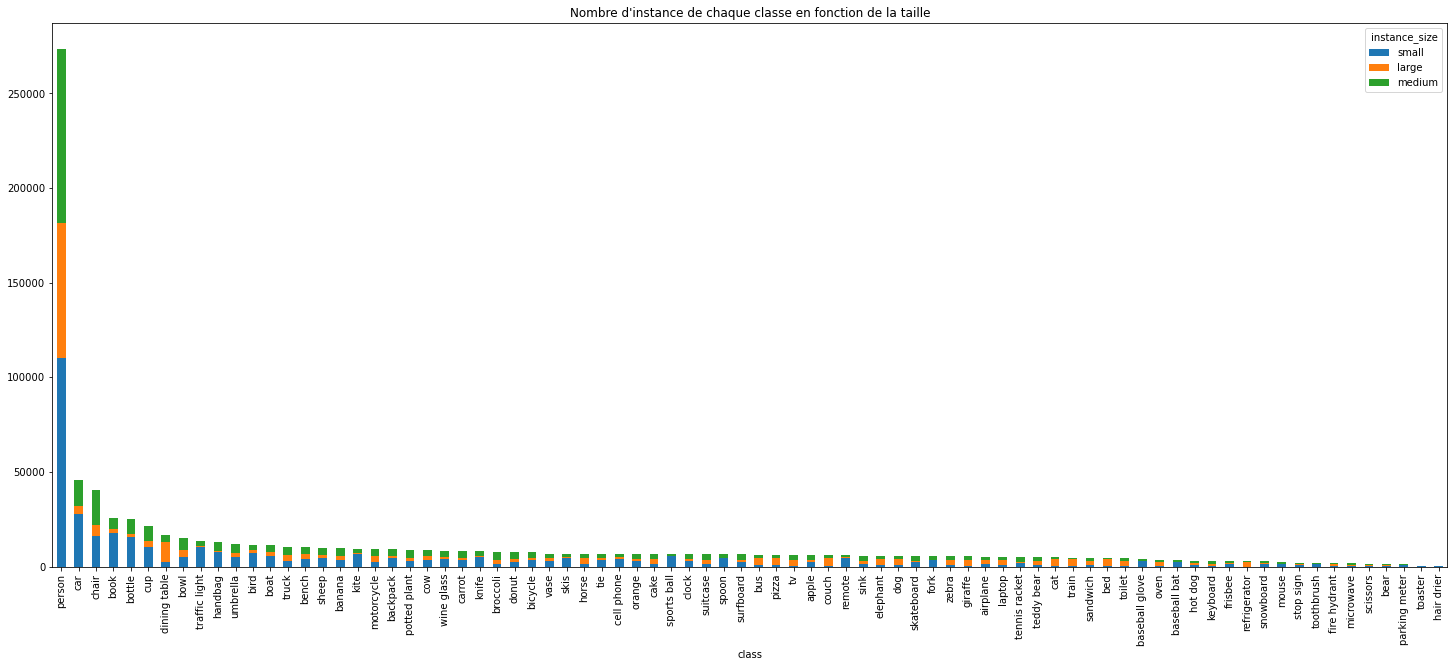

In [239]:
(
    occMats["all"]
        .sum()
        .unstack(level=1)
        .sort_values(by="total", ascending=False)
        .plot.bar(stacked=True, y=["small", "large", "medium"], title="Nombre d'instances de chaque classe en fonction de la taille")
)

<AxesSubplot:title={'center':"nombre d'apparitions des classes / taille d'instance / nombre d'images"}, xlabel='class'>

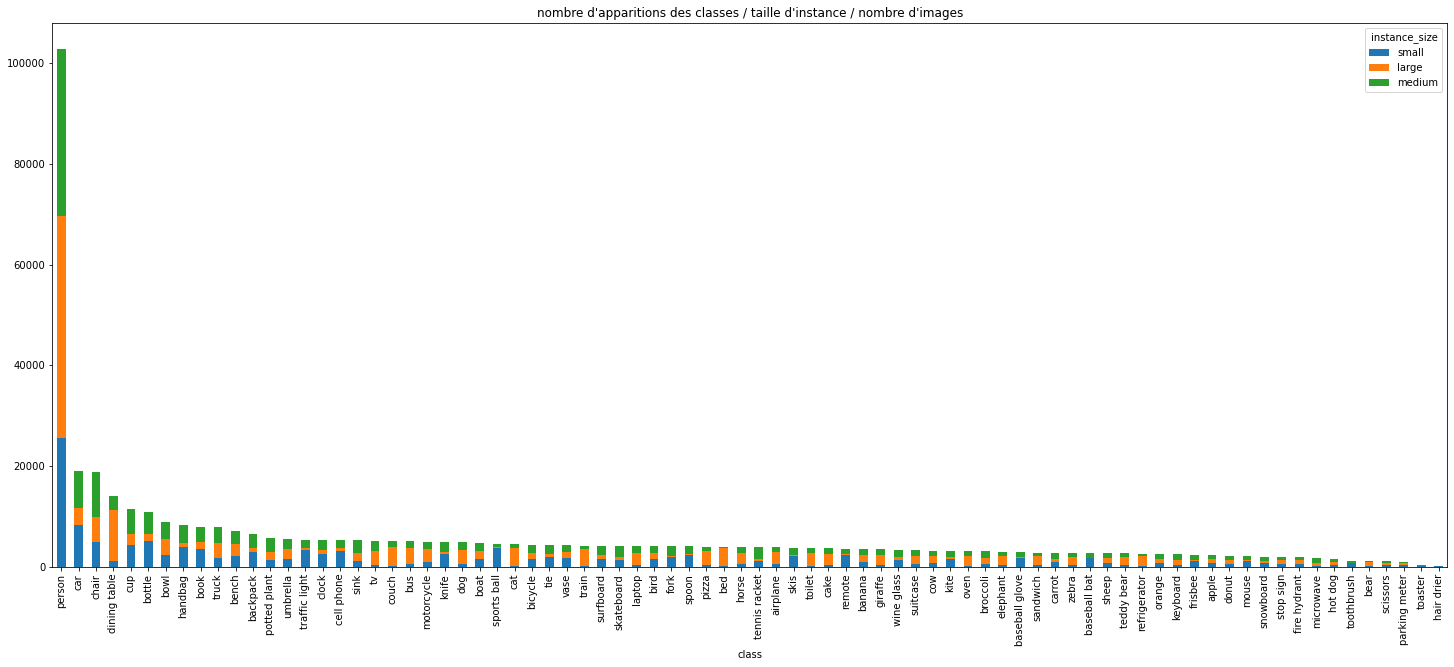

In [289]:
(
    occMats["all"]
        .astype(bool)
        .astype(int)
        .sum()
        .unstack(level=1)
        .assign(total = lambda x : x[["large", "medium", "small"]].sum(axis=1))
        .sort_values(by="total", ascending=False)
        .plot.bar(stacked=True, y=["small", "large", "medium"], title="nombre d'apparitions des classes / taille d'instance / nombre d'images")
)

#### Note
- Supprimer les annotations des petits objets qui ne sont pas petits par définition :
    - person, car, truck, etc.
    - petites personnes sur des petits vélos
    - $\rightarrow$ établir des règle de filtrage avec l'IOU ?

In [121]:
occMats["all"].astype(bool)[("person", "small") and ("bicycle", "small")].astype(int).sum() / occMats["all"].astype(bool)[("person", "total") and ("bicycle", "total")].astype(int).sum()

0.4298735665980594

## Nombre d'occurence des couples de classes

In [280]:
df = occMats["all"].copy()
df.loc[:,("person", "total")] -= df.loc[:, "person"].loc[:, "small"] # Suppression des petites personnes, supprime 3k images
df = (df.xs(key="total", axis=1, level=1)>0).astype("int")
df = df[df.sum(axis=1) > 1] # Supression des images avec une seule classe, supprime 30k images

In [281]:
df

class,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,...,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
397133,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
37777,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
252219,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
87038,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174482,0,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444010,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565004,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
516168,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
547503,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [282]:
df_occ_couples = (df.T @ df) #
np.fill_diagonal(df_occ_couples.values, 0)

In [283]:
df_occ_couples

class,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,...,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
class,,,,,,,,,,,,,,,,,,,,,
person,0,2412,6785,2569,463,2154,965,2936,1255,1773,...,48,1015,882,2315,1626,841,400,860,102,562
bicycle,2412,0,1287,478,19,451,111,469,129,483,...,1,8,19,74,101,20,6,26,0,4
car,6785,1287,0,1436,366,2227,446,3816,277,2651,...,1,11,36,96,521,42,10,82,2,10
motorcycle,2569,478,1436,0,17,313,27,662,24,337,...,0,0,5,26,52,4,1,16,1,0
airplane,463,19,366,17,0,74,8,661,80,23,...,0,1,2,8,12,1,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vase,841,20,42,4,1,3,2,8,11,4,...,26,445,217,712,282,0,35,65,10,30
scissors,400,6,10,1,0,0,0,5,0,1,...,12,71,31,147,36,35,0,9,2,15
teddy bear,860,26,82,16,2,8,7,17,12,7,...,2,16,13,277,48,65,9,0,3,11


In [285]:
from chord import Chord

In [292]:
Chord(df_occ_couples.values.tolist(), 
      df0.columns.to_list(), 
      wrap_labels=False,
      margin=10).show()

In [201]:
labels = (df_occ_couples
 .sum()
 .sort_values(ascending=False)
 .index
)
X, Y = labels[0:1], labels[1:]
sankey_df = pd.DataFrame(columns=["x", "y", "nb_occ"])
for x, y in itertools.product(X, Y):
    sankey_df= sankey_df.append({"x":x, "y":y, "nb_occ":df_occ_couples[x][y]}, ignore_index=True)

<AxesSubplot:title={'center':"nombre d'images contenant le couple (person, ?)"}, xlabel='y', ylabel="nombre d'images">

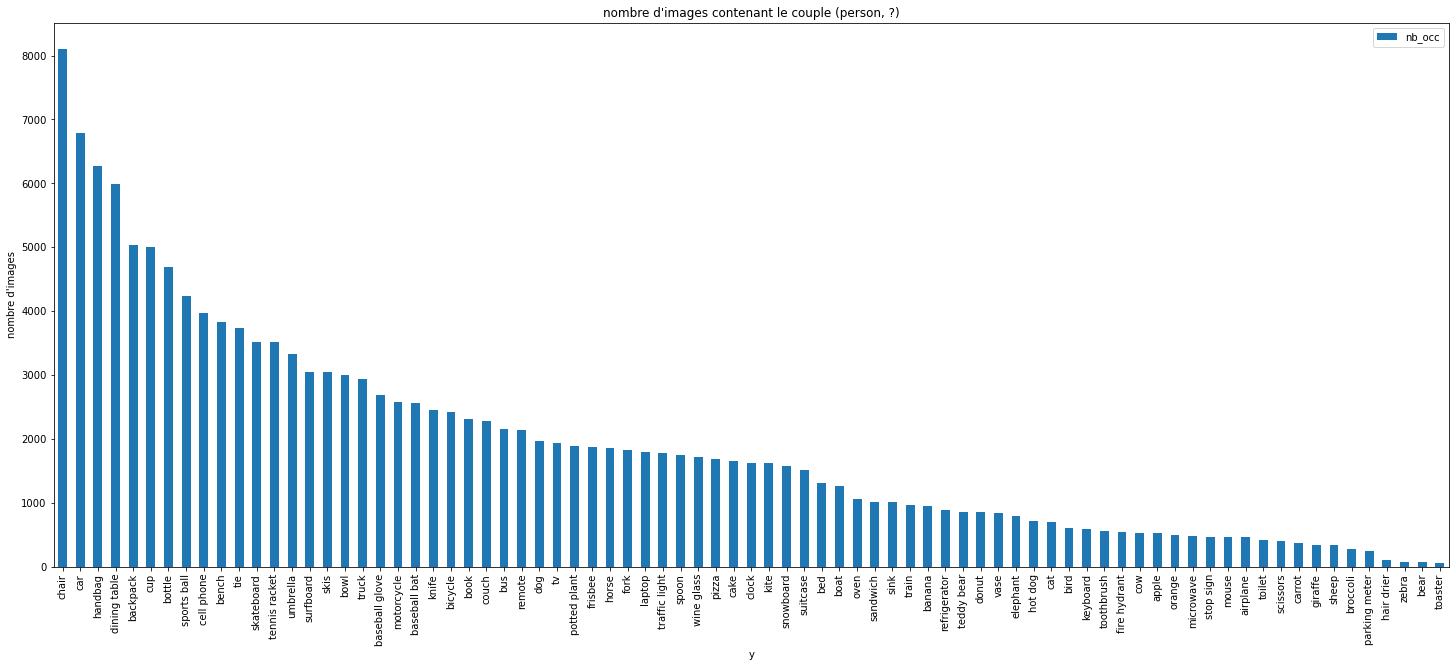

In [290]:
(
    sankey_df[["y", "nb_occ"]]
        .sort_values(by="nb_occ", ascending=False)
        .plot.bar(x="y", title="nombre d'images contenant le couple ({}, ?)".format(sankey_df["x"][0]), ylabel="nombre d'images")
)

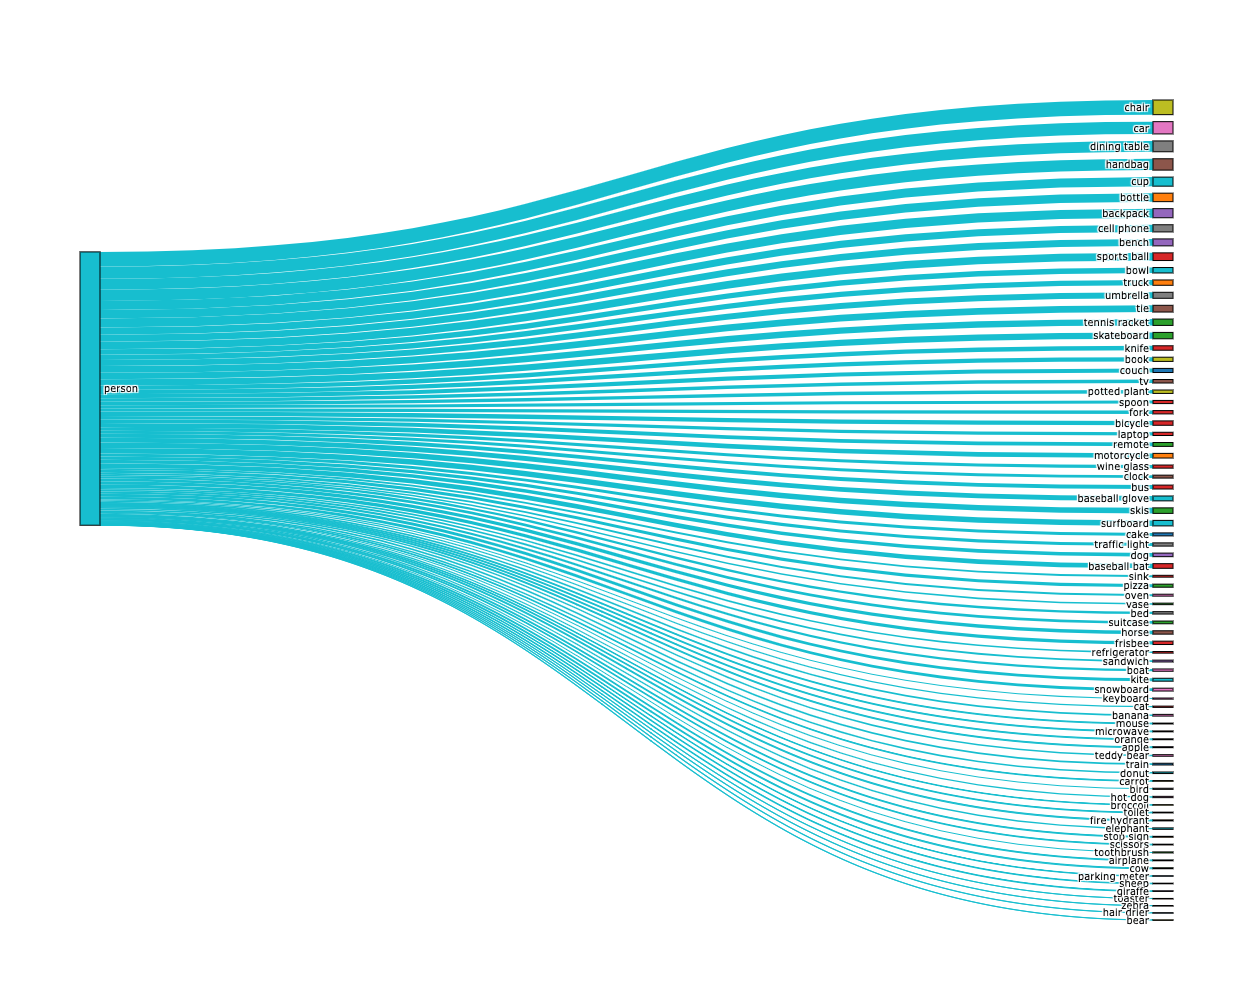

In [291]:
labels = (df_occ_couples
 .sum()
 .sort_values(ascending=False)
 .index
)

X, Y = labels[0:1], labels[1:]
sankey_df = pd.DataFrame(columns=["x", "y", "nb_occ"])
for x, y in itertools.product(X, Y):
    sankey_df= sankey_df.append({"x":x, "y":y, "nb_occ":df_occ_couples[x][y]}, ignore_index=True)

all_nodes = sankey_df.x.values.tolist() + sankey_df.y.values.tolist()
source_indices = [all_nodes.index(x) for x in sankey_df.x]
target_indices = [all_nodes.index(y) for y in sankey_df.y]

colors = pex.colors.qualitative.D3

node_colors_mappings = dict([(node,np.random.choice(colors)) for node in all_nodes])
node_colors = [node_colors_mappings[node] for node in all_nodes]
edge_colors = [node_colors_mappings[node] for node in sankey_df.x]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 20,
      line = dict(color = "black", width = 1.0),
      label =  all_nodes,
      color =  node_colors,
    ),

    link = dict(
      source =  source_indices,
      target =  target_indices,
      value =  sankey_df.nb_occ,
      color = edge_colors,
))])

fig.update_layout(
                  height=1000,
                  font_size=10)